In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import os

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#voc_classes = ['ALB', 'BET', 'DOL', 'LAG', 'SHARK', 'YFT']
NUM_CLASSES = 2

# from training, I pushed my weights with best validation error
weights = '/home/ryan/cs/datasets/ncfm/ssd_output_weights/weights.18-1.06.hdf5'

# path to test images
fish_path = '/home/ryan/cs/datasets/ncfm/test/'

# path where you want to save the predictions
save_path = '/home/ryan/cs/datasets/ncfm/bbox_predictions.pkl'

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
#model.load_weights('checkpoints/weights_SSD300.hdf5', by_name=True)
model.load_weights(weights, by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
sorted_names = sorted(os.listdir(fish_path))

inputs = []
images = []

for fname in sorted_names:
    if fname.endswith('.jpg'):
        img_path = os.path.join(fish_path, fname)
        img = image.load_img(img_path, target_size=(300,300))
        img = image.img_to_array(img)
        images.append(imread(img_path))
        inputs.append(img.copy())

print "Finished loading images."

inputs = preprocess_input(np.array(inputs))
print "Finished preprocessing input."

Finished loading images.
Finished preprocessing input.


In [5]:
preds = model.predict(inputs, batch_size=1, verbose=1)

1000/1000 [==============================] - 12s      

In [6]:
print preds.shape

(1000, 7308, 14)


In [7]:
# do we lose important information in this method?
results = bbox_util.detection_out(preds)

In [8]:
# this is currently the data structure I use to input
# into my submission generating ipython notebook
print len(results)
print results[0].shape

1000
(200, 6)


In [9]:
import pickle
pickle.dump(results, open(save_path,'w'), )

In [10]:
# %%time
# a = model.predict(inputs, batch_size=1)
# b = bbox_util.detection_out(preds)

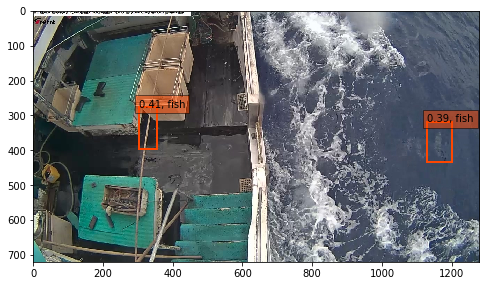

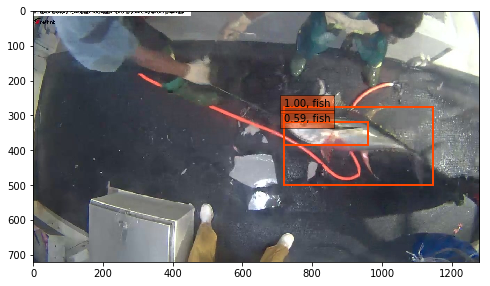

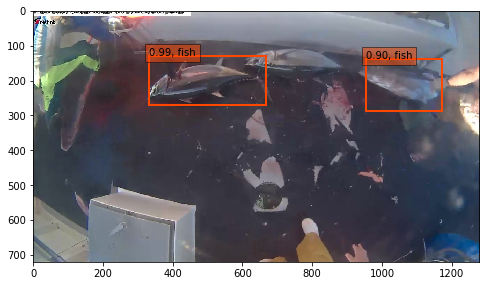

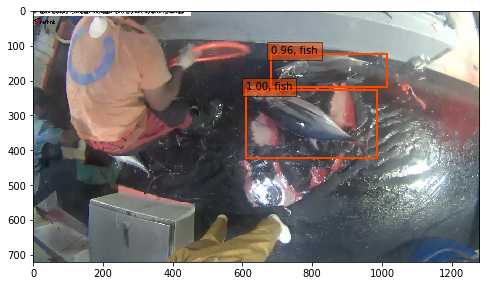

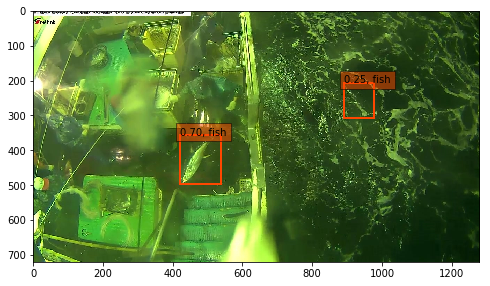

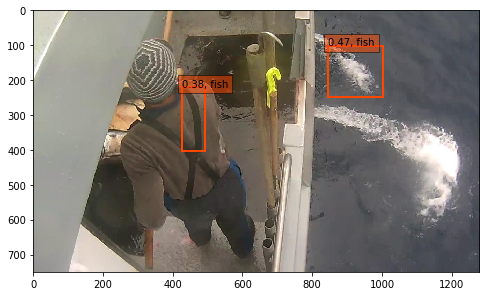

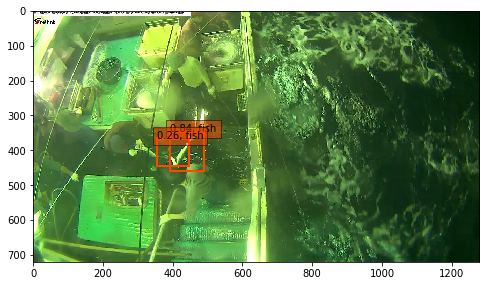

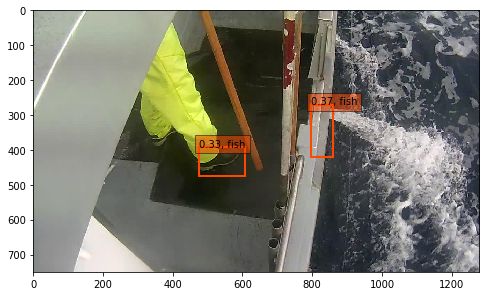

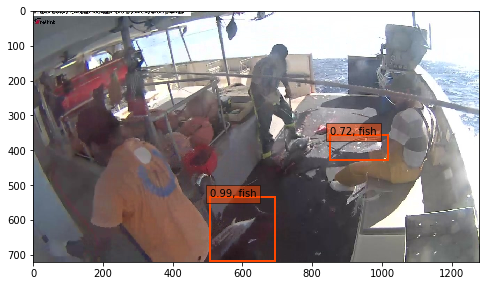

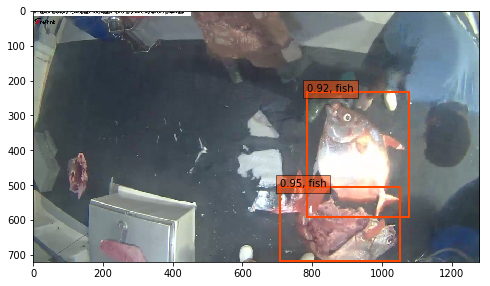

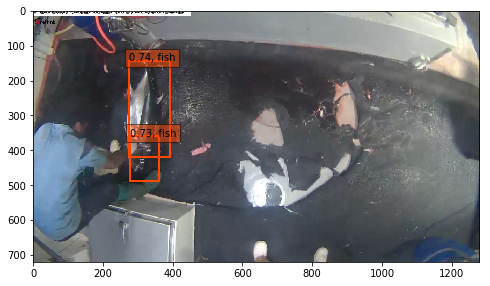

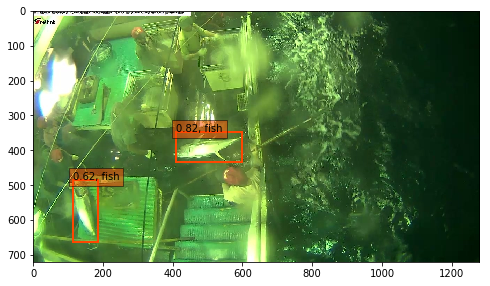

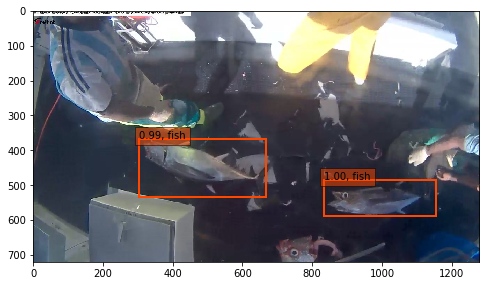

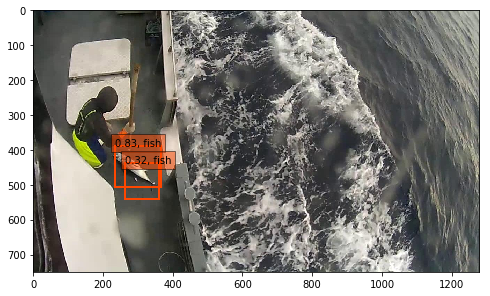

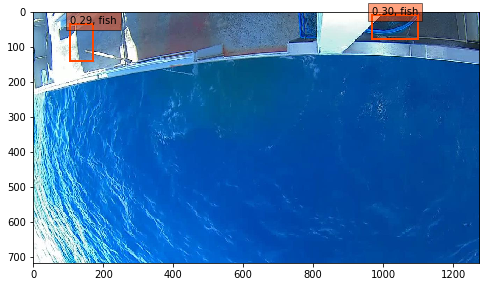

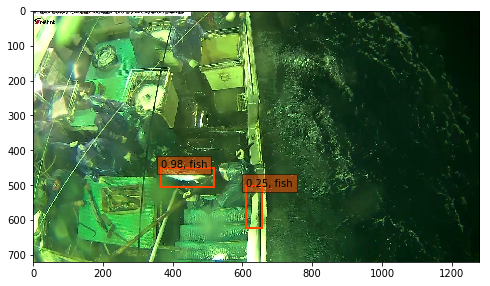

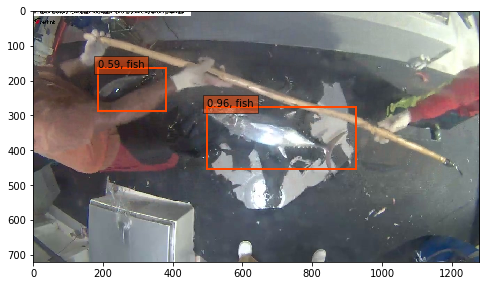

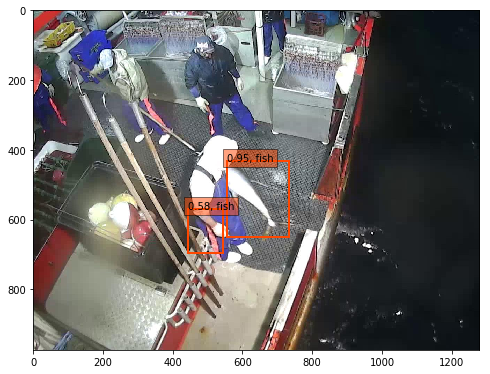

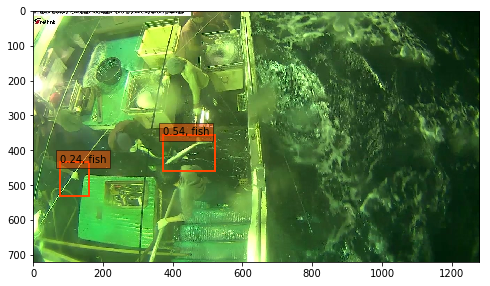

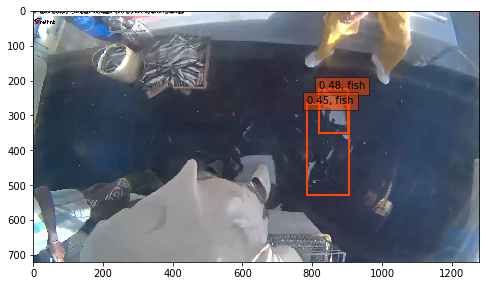

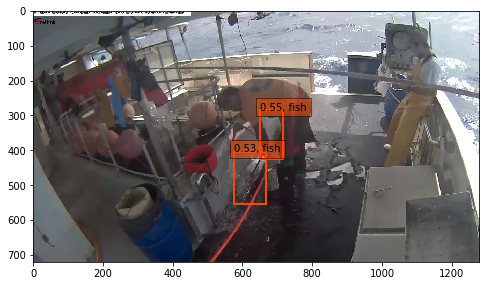

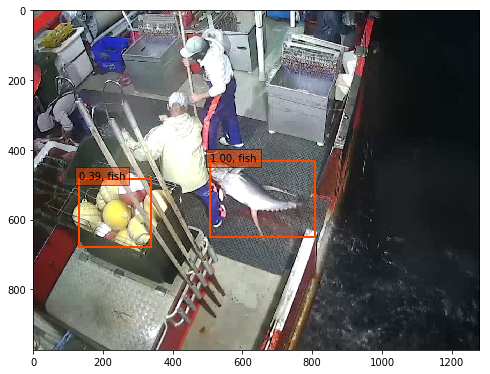

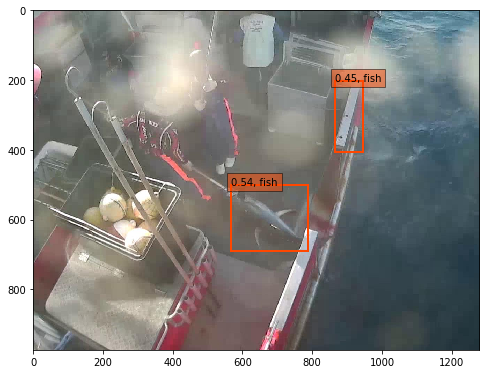

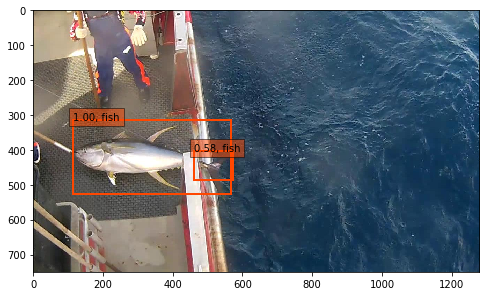

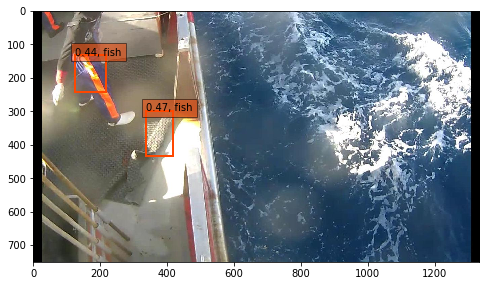

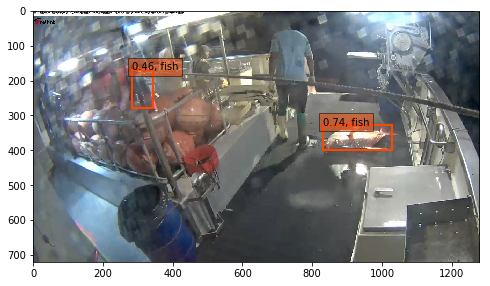

In [16]:
counter = 0 
for i, img in enumerate(images):
    
    if counter > 25:
        break
    counter += 1
    
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    #top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    k = det_conf.argsort()[::-1]
    top_indices = k[:2]
    
        
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        #label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, 'fish')
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()